In [1]:
from IPython.display import HTML
from sklearn.neighbors import NearestNeighbors

In [2]:
import pandas as pd
import networkx as nx
import community
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import numpy as np
from collections import defaultdict
from sklearn.neighbors import BallTree
import gc
%matplotlib inline

columns = ["pubId", "is_hourly", "seqId", "on_homepage", "canonicalUrl",
                   "firstScrape", "lang_iso", "lang_reliability", "title", "text"]

def read_article_df(file):
    articles_dt = file.read().split('\n')[:-1]
    pubId, canonicalUrl,firstScrape,title,text,lang_reliability = [],[],[],[],[],[]
    lang_iso = []
    for article in articles_dt:    
        row = article.split('\t')
        pubId.append(row[0])
        canonicalUrl.append(row[4])
        firstScrape.append(row[5])
        lang_iso.append(row[6])
        lang_reliability.append(row[7])
        title.append(row[8])
        text.append(row[9])

    articles_df = pd.DataFrame()
    articles_df['pubId'] = pubId
    articles_df['canonicalUrl'] = canonicalUrl
    articles_df['firstScrape'] = firstScrape
    articles_df['title'] = title
    articles_df['text'] = text
    articles_df['lang_reliability'] = lang_reliability
    articles_df['lang_iso'] = lang_iso
    return articles_df

In [3]:
emb_df = pd.read_csv('../data/embedding/Doc2Vec_embedding_output.csv',index_col=0)

In [4]:
emb_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-2.146739,-2.738958,3.672001,4.319488,2.060131,1.106603,2.756807,-1.807586,3.119252,-0.814754,...,2.498754,-1.766720,0.291909,-0.236563,0.366089,-2.615653,2.517367,-2.121267,4.024024,1.430665
1,-3.081997,-4.560731,-0.439482,2.801814,-2.063705,0.320462,2.700044,-1.313459,2.488874,-1.288608,...,3.506879,1.340675,0.644034,0.583566,-1.396967,-2.599615,0.540591,-0.846946,0.476570,1.209218
2,-0.923654,-0.931160,0.270649,0.993372,1.246490,1.068892,0.833382,-0.559276,1.961053,-4.149379,...,5.081479,1.130174,-2.890191,-2.820214,1.395403,-3.846228,-1.152302,-2.224700,1.176310,-0.315757
3,-0.047425,-3.906727,0.635823,0.752494,1.742398,0.973911,0.725889,-0.415176,3.048928,-2.944524,...,3.968297,0.803104,-1.049701,-2.646564,0.847253,-2.600662,-0.752832,0.028893,-0.424166,-1.445955
4,-6.648052,-0.395714,2.429264,2.590817,-0.684888,-1.006098,0.028183,2.124310,1.596855,-2.533973,...,-1.403458,-1.843892,-0.527678,-3.595732,-2.341160,-1.960664,-0.313663,-3.191498,0.681570,-2.437148


In [5]:
article_df = read_article_df(open('../data/raw/2018_07_19_04_59_08/articles.txt', encoding='utf-8'))
article_df = article_df[article_df.lang_reliability == '1'].reset_index(drop=True)

In [6]:
article_df['title'] = article_df.title.apply(lambda s: s.strip())
article_df['text'] = article_df.text.apply(lambda s: s.strip())
article_df['title_len'] = article_df.title.apply(len)
article_df['text_len'] = article_df.text.apply(len)

In [7]:
clean_df = article_df[article_df.title_len > 0]
clean_df = clean_df[clean_df.text_len > 100]
clean_df = clean_df[clean_df.lang_iso == 'en']
clean_df.shape

(176664, 9)

In [9]:
label1 = pd.read_csv('../data/raw/labels/cave_rescue/population.txt', header=None)
label1.columns = ['canonicalUrl']
label1['label'] = 'cave_rescue'

label2 = pd.read_csv('../data/raw/labels/duckboat/population.txt', header=None)
label2.columns = ['canonicalUrl']
label2['label'] = 'duckboat'

label3 = pd.read_csv('../data/raw/labels/helsinki_summit/population.txt', header=None)
label3.columns = ['canonicalUrl']
label3['label'] = 'helsinki'

In [10]:
label_df = pd.concat([label1, label2, label3])
label_df

,canonicalUrl,label
0,denverpost.com/2018/07/20/greeley-police-lip-s...,cave_rescue
1,bbc.com/news/av/world-asia-44875089/thai-cave-...,cave_rescue
2,news.google.com/stories/caaqzggkimbdqkltuwpvsm...,cave_rescue
3,chron.com/news/crime/article/young-nubians-rev...,cave_rescue
4,cnbc.com/2018/07/20/at-least-13-die-when-duck-...,cave_rescue
...,...,...
1920,beforeitsnews.com/opinion-conservative/2018/07...,helsinki
1921,washingtonpost.com/news/powerpost/paloma/the-h...,helsinki
1922,feeds.nydailynews.com/~r/nydnrss/news/national...,helsinki
1923,news.google.com/stories/caaqoqgkijndqkltsurvsm...,helsinki


In [11]:
clean_df = clean_df.merge(label_df, on='canonicalUrl', how='left')

In [12]:
clean_df.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label
0,290,zerohedge.com/news/2018-07-19/i-told-you-so-tr...,7/19/2018 10:41:26 AM -04:00,"""I Told You So"": Trump Hits Out At EU After $5...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,79,2134,NaN
1,290,zerohedge.com/news/2018-07-19/trump-invites-pu...,7/19/2018 5:03:01 PM -04:00,Trump Invites Putin To Ahead Of Midterms | Ze...,"by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,54,4555,NaN
2,290,zerohedge.com/news/2018-07-19/gallup-shows-how...,7/19/2018 8:26:52 AM -04:00,Gallup Shows How Much Americans Really Care Ab...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,76,3133,NaN
3,290,zerohedge.com/news/2018-07-19/california-supre...,7/19/2018 8:26:52 AM -04:00,California Supreme Court Blocks Proposal To Sp...,"by Knave Dave - Jul 18, 2018 1:11 pm ### This ...",1,en,85,3567,NaN
4,290,zerohedge.com/news/2018-07-19/why-are-thousand...,7/19/2018 4:28:52 PM -04:00,"Why Are ""Thousands"" of Teslas Sitting In a Fie...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,62,3584,NaN


In [13]:
article_with_label = clean_df[~clean_df.label.isna()]
article_without_label = clean_df[clean_df.label.isna()]
article_with_label.shape, article_without_label.shape

((624, 10), (176045, 10))

Sample and include all the labeled article

In [14]:
sample_df = pd.concat([article_with_label, article_without_label.sample(10000)])

In [15]:
sample_emb_df = emb_df.loc[sample_df.index]

In [16]:
nn = NearestNeighbors(n_neighbors=10, metric='cosine')
nn.fit(sample_emb_df)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [17]:
admat = nn.kneighbors_graph( mode='connectivity'); admat

<10624x10624 sparse matrix of type '<class 'numpy.float64'>'
	with 106240 stored elements in Compressed Sparse Row format>

In [18]:
G = nx.from_scipy_sparse_matrix(admat)

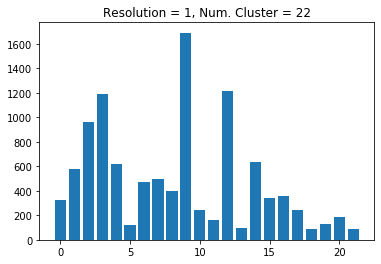

In [19]:
partitions = []
resolutions = [1] #, .99, .999, .9995, .9999]
for resolution in resolutions:
    partition = community.best_partition(G, resolution=resolution)
    partitions.append(partition)
    num_cluster = max([v for k,v in partition.items()]) + 1
    clusters = defaultdict(list)
    for k, v in partition.items():
        clusters[v].append(k)

    cluster_sizes = []
    for i, cluster in clusters.items():
        cluster_sizes.append(len(cluster))
    plt.bar(list(range(len(cluster_sizes))), cluster_sizes)
    plt.title(f'Resolution = {resolution}, Num. Cluster = {num_cluster}')
    plt.show()

In [20]:
np.argmax(cluster_sizes), np.max(cluster_sizes), np.median(cluster_sizes)

(9, 1690, 349.0)

In [21]:
def plot_cluster_sizes(cluster):
    cluster_sizes = []
    for i, c in cluster.items():
        cluster_sizes.append(len(c))
    plt.title(f'Num cluster = {len(cluster.keys())}')
    plt.hist(cluster_sizes)
    plt.show()
    
def prune_cluster(cluster: dict, threshold) -> dict:
    pc = {}
    for key, value in clusters.items():
        if len(value) > threshold:
            pc[key] = value
    return pc

In [22]:
pc = clusters# prune_cluster(cluster, 5)

In [23]:
article_cluster = list(map(lambda d: sample_df.iloc[d[1]], pc.items()))
len(article_cluster)

22

In [24]:
len(article_cluster[0].title.tolist())

321

In [25]:
pc.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])

In [26]:
n = len(pc.keys())
sample_cluster = np.random.randint(n)
print('-'*50, 'title', '-'*50)
print('\n'.join(article_cluster[sample_cluster].title.tolist()[:10]))
print('-'*50, 'text', '-'*50)
print('\n'.join(list(map(lambda x: x[:100], article_cluster[sample_cluster].text.tolist()[:10]))))

-------------------------------------------------- title --------------------------------------------------
New tactic by politicians: Set up fake news websites as a campaign gamb
Appalachian Trail hiker rescued twice in Maine in two weeks
Arkansas man gets 7 years for selling guns to felon in Chicago area | Chicago Sun-Times
He's In Prison With Terrorists — For Medical Marijuana. Now He Wants Trump's Help
Twitter Is Screaming Over  Facial Expression After Meeting Putin
players and coach speak publicly for first time since their rescue from flooded cave
Comic-Con: Who would win if 'The Predator' took on Elsa, Han Solo?
Trump open to Russian questioning of former U.S. ambassador McFaul
California Lawmakers To Revive Trump Tax Return Bill « CBS San Francisco
Why You Might Not Want to Pay Off Your Student Loans Early | Fox Business
-------------------------------------------------- text --------------------------------------------------
New tactic by politicians: Set up fake news websites

## Top clusters

In [27]:
cluster_sizes = np.array(list(map(len, article_cluster)))

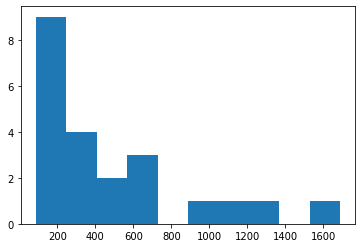

In [28]:
plt.hist(cluster_sizes);

In [29]:
index_by_size = list(reversed(np.argsort(cluster_sizes)))
cluster_sizes[index_by_size]

array([1690, 1211, 1192,  958,  637,  618,  578,  495,  471,  400,  357,
        341,  321,  244,  244,  185,  159,  126,  122,   99,   90,   86])

In [30]:
top_cluster = article_cluster[index_by_size[0]]
top_cluster.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label
10753,33,washingtonpost.com/news/capital-weather-gang/w...,7/19/2018 5:37:12 PM -04:00,"Dozens dead in Japan from record-setting, long...","Dozens dead in Japan from record-setting, long...",1,en,74,2257,helsinki
10801,33,washingtonpost.com/news/posteverything/wp/2018...,7/19/2018 6:27:03 AM -04:00,"Ukraine’s not a country, Putin told Bush. What...",PostEverything Perspective ### Perspective Int...,1,en,79,8487,helsinki
10851,33,washingtonpost.com/business/2018/07/17/federal...,7/19/2018 6:18:36 AM -04:00,Federal Reserve chair: Decline in worker share...,Federal Reserve chair: Decline in worker share...,1,en,83,3639,helsinki
11218,22,nytimes.com/1994/07/29/us/at-the-bar-defense-l...,7/19/2018 7:42:35 AM -04:00,At the Bar;Defense lawyer turns the tables on ...,NYTimes.com no longer supports Internet Explor...,1,en,81,5730,duckboat
11228,22,nytimes.com/2018/07/19/world/europe/heat-wave-...,7/19/2018 12:29:28 PM -04:00,Heat Wave Scorches Sweden as Wildfires Rage in...,Heat Wave Scorches Sweden as Wildfires Rage in...,1,en,66,8975,cave_rescue


In [31]:
print('\n'.join(top_cluster.title.tolist()[:10]))

Dozens dead in Japan from record-setting, long duration extreme heat event
Ukraine’s not a country, Putin told Bush. What’d he tell Trump about Montenegro
Federal Reserve chair: Decline in worker share of national economy ‘very troubling’
At the Bar;Defense lawyer turns the tables on the prosecutors but pays a price. -
Heat Wave Scorches Sweden as Wildfires Rage in the Arctic Circle -
duck boat capsized in Missouri - Overview
meets Vladimir Putin - Overview
Stocks slide after disappointing earnings, Trump dumps on Fed | Seeking Alpha
Scout leader drowns rescuing boy in Utah pond - news - CenturyLink
3 Sonoma County men arrested in murder of Cloverdale man missing since June - news - CenturyLink


In [32]:
for i, a in enumerate(article_cluster):
    a['assignment'] = i

/Users/tniyomkarn/via_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [104]:
articles = pd.concat(article_cluster)

In [105]:
articles.dropna(subset=['label'])

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label,assignment
11,290,zerohedge.com/news/2018-07-19/la-liberals-stag...,7/19/2018 7:50:19 PM -04:00,"LA Liberals Stage ""Emergency Protest"" At Koshe...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,75,3317,helsinki,0
10674,33,washingtonpost.com/local/obituaries/manny-ycaz...,7/19/2018 7:17:12 PM -04:00,"Manny Ycaza, hall of fame jockey of fire and f...","Obituaries ### Manny Ycaza, hall of fame jocke...",1,en,64,7403,duckboat,0
10852,33,washingtonpost.com/opinions/help-is-at-hand-fo...,7/19/2018 6:44:22 PM -04:00,Help is at hand for Palestinians — if Hamas se...,Help is at hand for Palestinians — if Hamas se...,1,en,58,5325,helsinki,0
11097,232,barrons.com/articles/lamborghini-spyder-makes-...,7/19/2018 2:11:38 PM -04:00,Lamborghini Spyder Makes North American Debut ...,What are you searching for? To order presenta...,1,en,56,4867,helsinki,0
11229,22,nytimes.com/2018/07/19/world/europe/heat-wave-...,7/19/2018 12:29:28 PM -04:00,Heat Wave Scorches Sweden as Wildfires Rage in...,Heat Wave Scorches Sweden as Wildfires Rage in...,1,en,66,8975,duckboat,0
...,...,...,...,...,...,...,...,...,...,...,...
120349,220,clickondetroit.com/money/chinas-yuan-plunges-a...,7/19/2018 8:27:35 AM -04:00,China's yuan plunges again. Is a currency war ...,China's yuan plunges again. Is a currency war ...,1,en,53,3352,helsinki,20
135519,44,dailymail.co.uk/news/article-5968683/mac-cliff...,7/19/2018 6:48:33 AM -04:00,Mac on... Cliff Richard | Daily Mail Online,"Thursday, Jul 19th 2018 5-Day Forecast ### Adv...",1,en,45,813,helsinki,20
135812,44,dailymail.co.uk/tvshowbiz/article-5970199/chri...,7/19/2018 8:27:14 AM -04:00,films hilarious clip of Luna tucking into past...,comments ### She is well-known for her love of...,1,en,67,3483,duckboat,20
161462,174,triblive.com/local/monroeville/13879453-74/ass...,7/19/2018 5:10:21 AM -04:00,"Assault, DUI cases among those recently handle...","Obituaries Front ### - - - - - ### Assault, DU...",1,en,63,2630,duckboat,20


In [106]:
assignments = articles[['label', 'assignment', 'canonicalUrl']].groupby(['label', 'assignment']).count()

In [107]:
HTML(assignments.to_html())

## Evaluate

In [108]:
cluster_to_prediction = pd.DataFrame(articles[['label', 'assignment', 'canonicalUrl']].groupby("assignment").apply(lambda x: x['label'].mode()))
cluster_to_prediction = cluster_to_prediction.reset_index().groupby('assignment').apply(lambda x: x.sample(1)).reset_index(drop = True)[['assignment', 0]]

In [109]:
cluster_to_prediction.columns = ['assignment', 'prediction']
cluster_to_prediction

,assignment,prediction
0,0,helsinki
1,1,helsinki
2,2,helsinki
3,3,helsinki
4,4,helsinki
5,5,helsinki
6,6,helsinki
7,7,helsinki
8,8,helsinki
9,9,helsinki


In [110]:
articles = articles.merge(cluster_to_prediction, on=('assignment'))
articles['label'].fillna('unlabeled', inplace=True)
articles.head()

,pubId,canonicalUrl,firstScrape,title,text,lang_reliability,lang_iso,title_len,text_len,label,assignment,prediction
0,290,zerohedge.com/news/2018-07-19/la-liberals-stag...,7/19/2018 7:50:19 PM -04:00,"LA Liberals Stage ""Emergency Protest"" At Koshe...","by Phoenix Capita… - Jul 19, 2018 8:49 am ### ...",1,en,75,3317,helsinki,0,helsinki
1,33,washingtonpost.com/local/obituaries/manny-ycaz...,7/19/2018 7:17:12 PM -04:00,"Manny Ycaza, hall of fame jockey of fire and f...","Obituaries ### Manny Ycaza, hall of fame jocke...",1,en,64,7403,duckboat,0,helsinki
2,33,washingtonpost.com/opinions/help-is-at-hand-fo...,7/19/2018 6:44:22 PM -04:00,Help is at hand for Palestinians — if Hamas se...,Help is at hand for Palestinians — if Hamas se...,1,en,58,5325,helsinki,0,helsinki
3,232,barrons.com/articles/lamborghini-spyder-makes-...,7/19/2018 2:11:38 PM -04:00,Lamborghini Spyder Makes North American Debut ...,What are you searching for? To order presenta...,1,en,56,4867,helsinki,0,helsinki
4,22,nytimes.com/2018/07/19/world/europe/heat-wave-...,7/19/2018 12:29:28 PM -04:00,Heat Wave Scorches Sweden as Wildfires Rage in...,Heat Wave Scorches Sweden as Wildfires Rage in...,1,en,66,8975,duckboat,0,helsinki


[[ 372    4    0    0]
 [ 134    4    0    0]
 [ 109    1    0    0]
 [9833   81    0    0]]


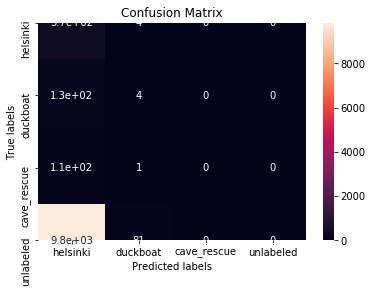

In [116]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
%matplotlib inline

labels = articles['label'].unique()
cm = confusion_matrix(list(articles['label']), list(articles['prediction']), labels)

print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = sns.heatmap(cm, annot=True, ax = ax);
plt.title('Confusion matrix of the classifier')
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [122]:
cm_without_unlabeled = cm[:-1, :-1]
acc = np.trace(cm_without_unlabeled)/np.sum(cm_without_unlabeled)
print("Accuracy: ", acc)

Accuracy:  0.6025641025641025


In [123]:
cm_without_unlabeled

array([[372,   4,   0],
       [134,   4,   0],
       [109,   1,   0]])

In [126]:
labeled_articles = articles.dropna(subset=['label'])
concat_labeled_articles = list(labeled_articles[['text','prediction']].groupby(['prediction'])['text'].apply(lambda x: ' '.join(x)))
# df[['name','text','month']].drop_duplicates()

In [128]:
from sklearn.feature_extraction.text import TfidfVectorizer

def avg_tfidf()
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(concat_labeled_articles)

In [133]:
vectors.todense()

matrix([[4.95778619e-04, 5.70145412e-03, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [2.97317710e-03, 7.42021708e-03, 1.30076161e-05, ...,
         1.30076161e-05, 1.30076161e-05, 3.25190402e-06]])

In [136]:
tfidfs = pd.DataFrame(vectors.toarray(), columns=vectorizer.get_feature_names())

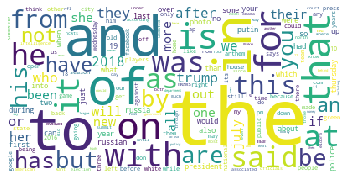

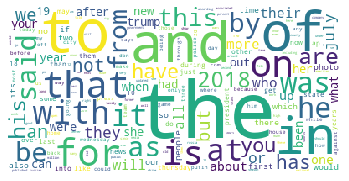

In [150]:
from wordcloud import WordCloud

for i in range(0, len(tfidfs)):
    wordcloud = WordCloud(background_color = 'white')
    d = {}
    for k,v in tfidfs.T[i].reset_index().values:
        d[k] = v
    d
    wc = wordcloud.generate_from_frequencies(d)
    plt.figure()
    plt.imshow(wc)
    plt.axis("off")